In [11]:
import requests
import pandas as pd
import xmltodict
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import networkx as nx

In [12]:
class ApiGetter():
    """
        Classe para fazer requests em APIs e tratar os erros de conexão
    """
    @staticmethod
    def get(url : str):
        try:
            response = requests.get(url)
            return response
        except requests.exceptions.RequestException as e:
            print(e)
            return None

class ApiXmlParser():
    """
        Classe para parsear xml de resposta de APIs, pois algumas respostas da API do senado vem em xml e outras json
    """
    @staticmethod
    def parse(xml : bytes, encoding : str):
        if xml is None:
            return None
        try:
            xml_decoded = xml.decode(encoding)
            return xmltodict.parse(xml_decoded)
        except Exception as e:
            print(e)
            return None
    
class AutorMateriaAnalytics():
    """
        Classe para fazer análises sobre os autores de matérias legislativas
    """

    def __init__(self):
        self.api_response = ApiGetter.get("https://legis.senado.leg.br/dadosabertos/autor/lista/atual")
        self.parsed_response = ApiXmlParser.parse(self.api_response.content, 'ISO-8859-1')
        self.dataframe_autores()
    
    def dataframe_autores(self):
        if self.parsed_response is None:
            return None
        try:
            autores = self.parsed_response['ListaAutores']['Autores']['Autor']
            df_autores = pd.DataFrame(autores, columns=['CodigoParlamentar', 'FormaTratamento', 'NomeParlamentar', 'QuantidadeMaterias'])
            df_autores['QuantidadeMaterias'] = pd.to_numeric(df_autores['QuantidadeMaterias'], errors='coerce')
            self.df_autores = df_autores
        except Exception as e:
            print(e)
            return None
    
    def autores_histogram(self, autores_types_list : list[str]):
        """
            Plotar um histrograma dado uma lista de tipos dos autores de materias legislativas eg. ['deputado', 'senador', 'congressista']
        """
        self.dataframe_autores()
        for autor_type in autores_types_list:
            current_df = None
            if autor_type == 'Congressistas':
                current_df = self.df_autores
            else:
                current_df = self.df_autores[self.df_autores['FormaTratamento'] == autor_type]
            y, x = np.histogram(current_df['QuantidadeMaterias'], bins=20)
            percentages = y / y.sum() * 100
            plt.figure(figsize=(20, 6))
            plt.text(0.95, 0.95, f'Total {autor_type.capitalize()}: {len(current_df)}', 
                    horizontalalignment='right', verticalalignment='top', 
                    transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
            plt.yticks(range(0, 500, 40))
            plt.xticks(range(0, 600, 20))
            current_df['QuantidadeMaterias'].plot(kind='hist', bins=20, edgecolor='black')
            for i in range(len(x) - 1):
                if percentages[i] > 0:
                    plt.text(x[i] + (x[i + 1] - x[i]) / 2, y[i], f'{percentages[i]:.1f}%', ha='center', va='bottom')
            plt.title(f'Histograma do número de materias com relação à quantidade de {autor_type.capitalize()}')
            plt.xlabel('Quantidade de Materias Legislativas')
            plt.ylabel(f'Número de {autor_type.capitalize()}')
            plt.grid(True)
            plt.show()

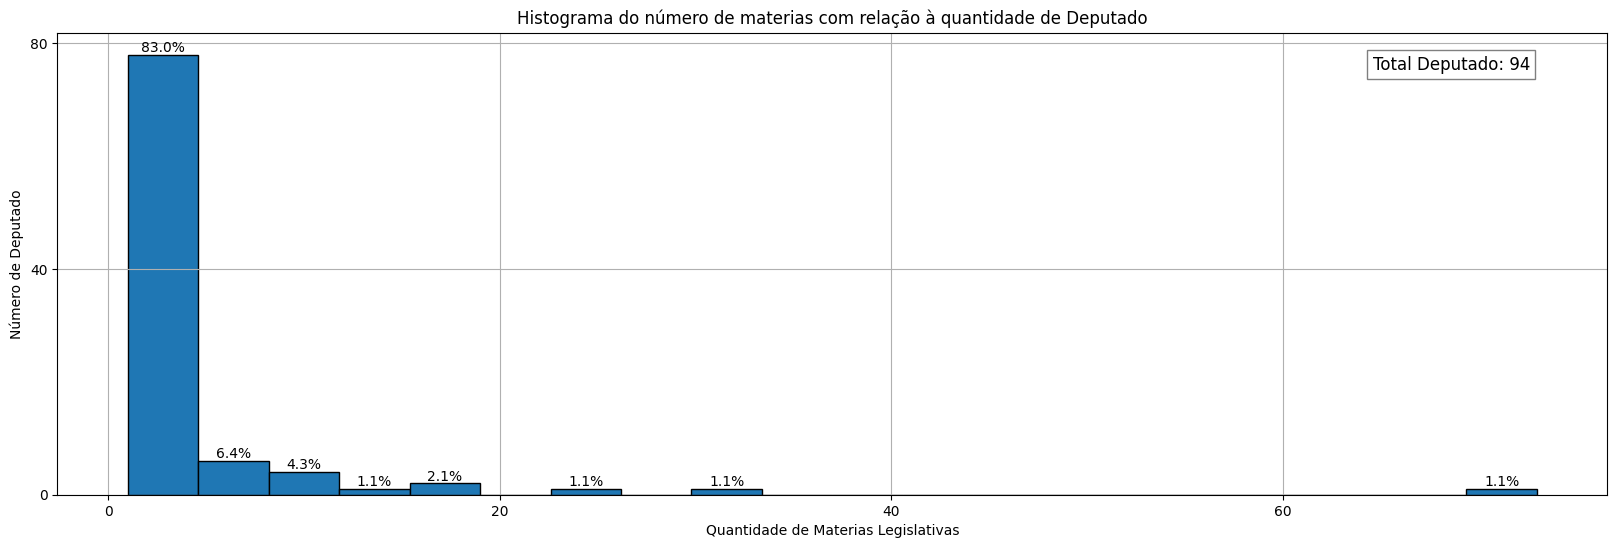

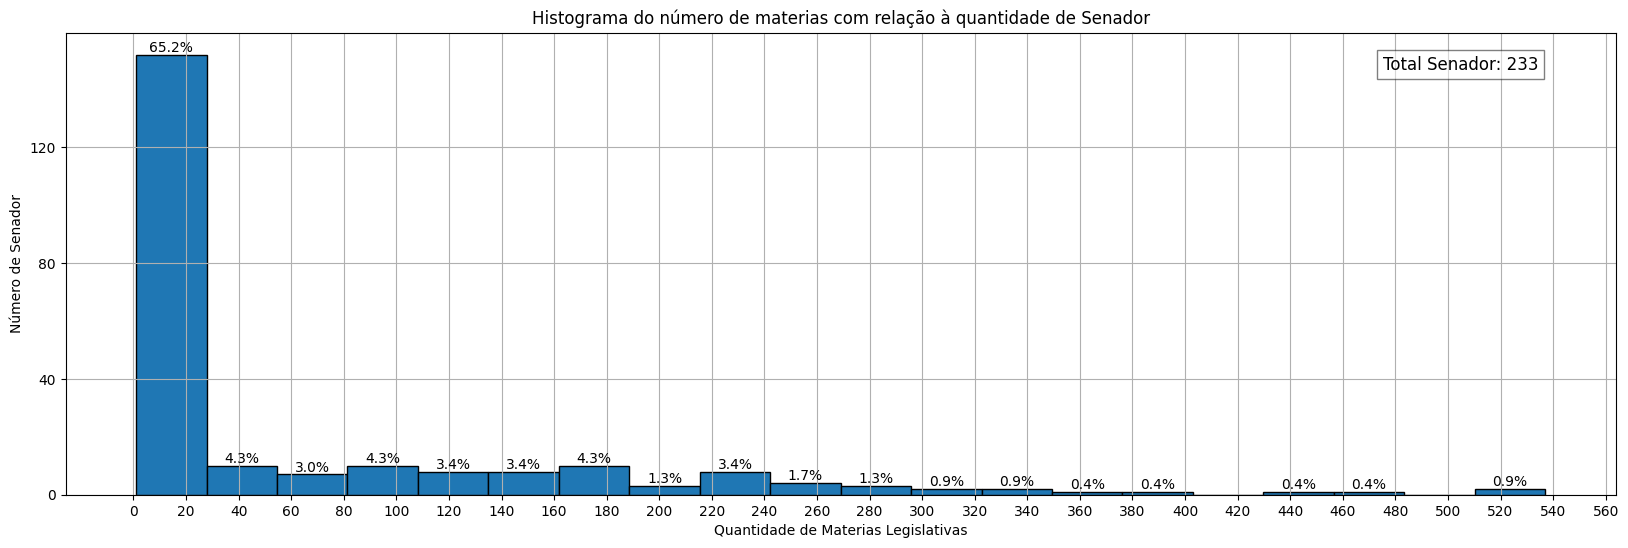

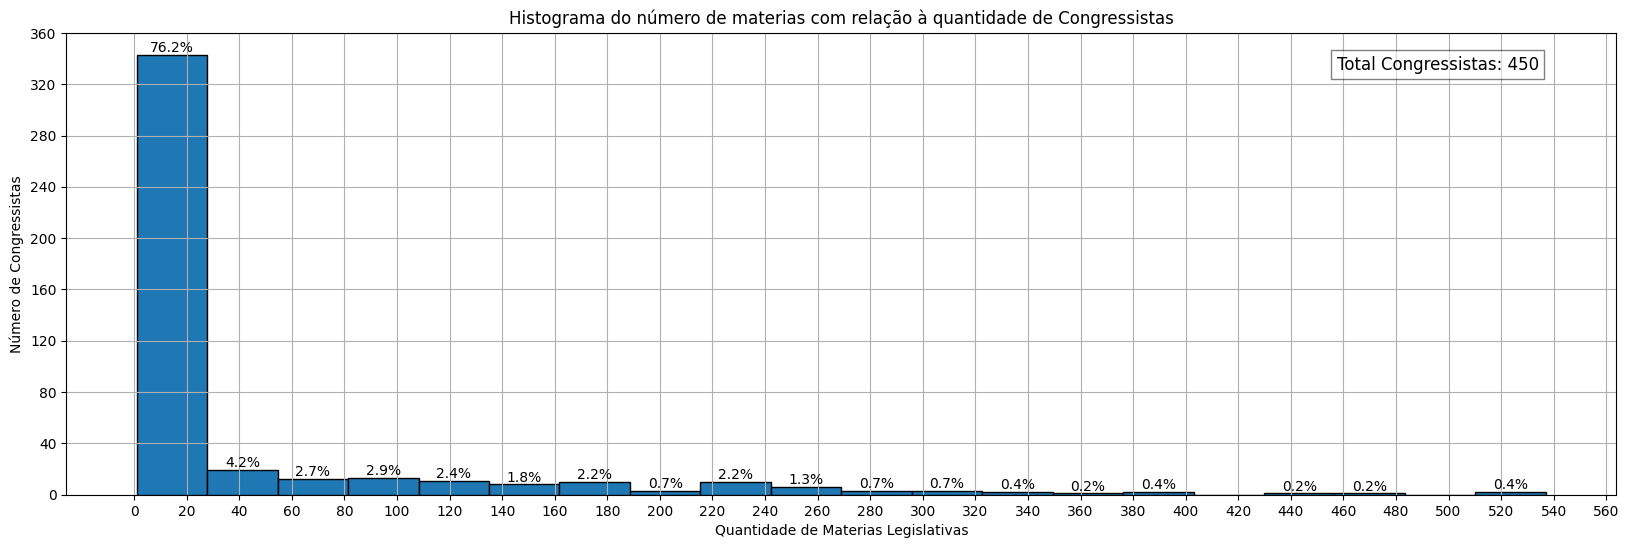

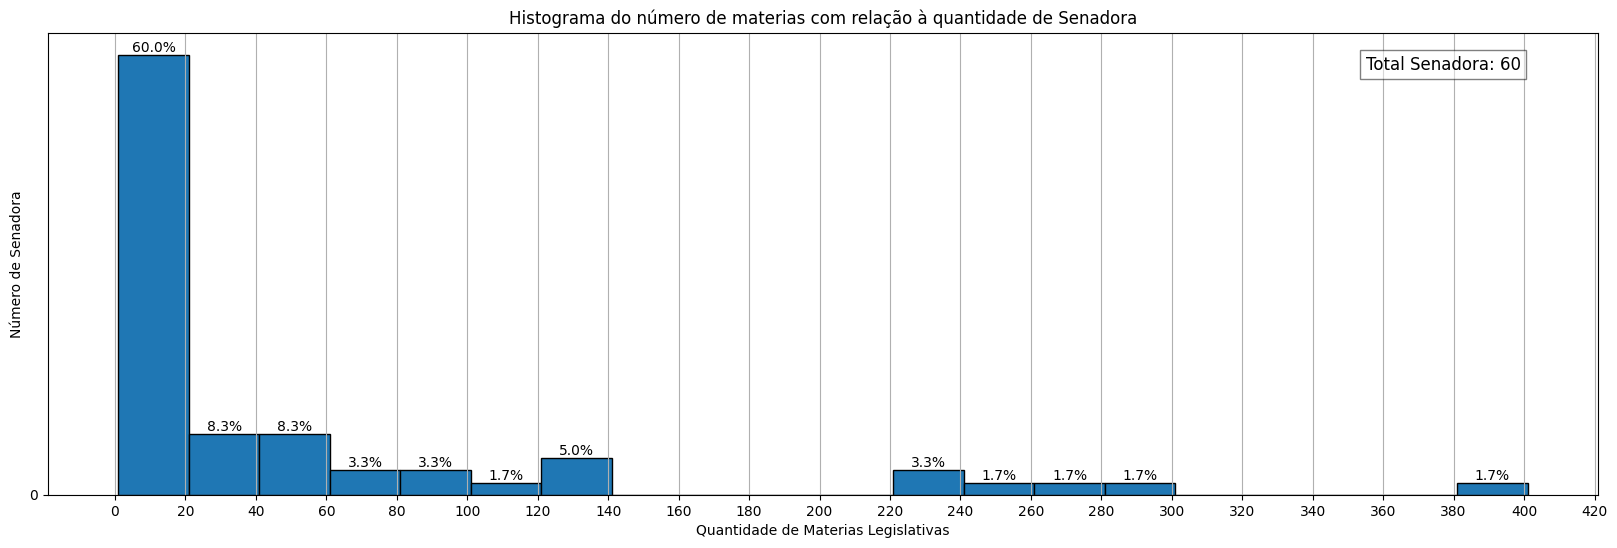

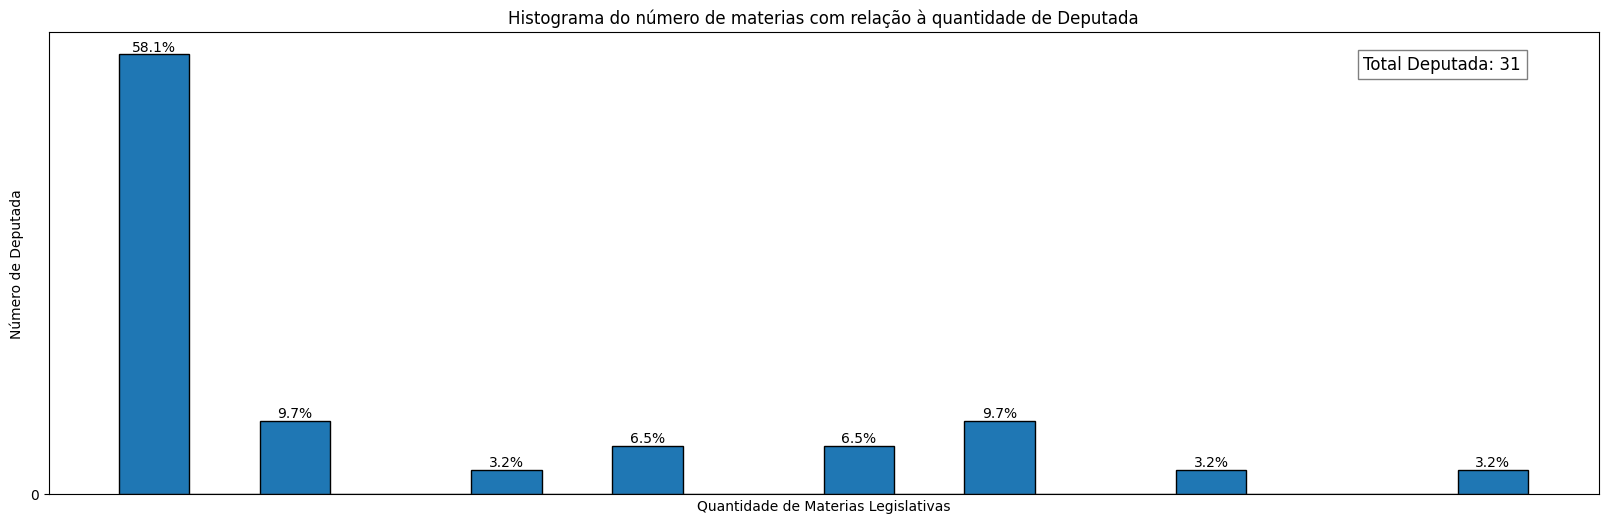

In [13]:
autor_analytics = AutorMateriaAnalytics()
autor_analytics.autores_histogram(['Deputado', 'Senador', 'Congressistas', 'Senadora', 'Deputada'])

In [14]:
class SenadoresAnalytics():
    """
        Classe para fazer análises sobre todos os senadores, afastados ou atuais e disponibilizar os dataframes.
    """
    def __init__(self):
        self.api_response_atuais = ApiGetter.get("https://legis.senado.leg.br/dadosabertos/senador/lista/atual")
        self.api_response_afastados = ApiGetter.get("https://legis.senado.leg.br/dadosabertos/senador/lista/afastados")
        self.parsed_response_atuais = ApiXmlParser.parse(self.api_response_atuais.content, 'utf-8')
        self.parsed_response_afastados = ApiXmlParser.parse(self.api_response_afastados.content, 'utf-8')
        self.df_senadores = None
        self.df_senadores_atuais = None
        self.merge_senadores()
    
    def merge_senadores(self):
        """
            Juntar os senadores atuais e afastados em um único dataframe
        """
        if self.parsed_response_atuais is None or self.parsed_response_afastados is None:
            return None
        try:
            senadores = []
            for senador_atual in self.parsed_response_atuais['ListaParlamentarEmExercicio']['Parlamentares']['Parlamentar']:
                senadores.append({
                    'CodigoParlamentar': senador_atual['IdentificacaoParlamentar']['CodigoParlamentar'],
                    'FormaTratamento': senador_atual['IdentificacaoParlamentar']['FormaTratamento'],
                    'NomeParlamentar': senador_atual['IdentificacaoParlamentar']['NomeParlamentar'],
                    'SiglaPartido': senador_atual['IdentificacaoParlamentar']['SiglaPartidoParlamentar'],
                    'Mandato': '1' if date.fromisoformat(senador_atual['Mandato']['SegundaLegislaturaDoMandato']['DataInicio']) < date.today() else '2',
                    'Afastamento': '0'
                })
            self.df_senadores_atuais = pd.DataFrame(senadores, columns=['CodigoParlamentar', 'FormaTratamento', 'NomeParlamentar', 'SiglaPartido', 'Mandato', 'Afastamento'])
            for senador_afastado in self.parsed_response_afastados['AfastamentoAtual']['Parlamentares']['Parlamentar']:
                senadores.append({
                    'CodigoParlamentar': senador_afastado['IdentificacaoParlamentar']['CodigoParlamentar'],
                    'FormaTratamento': senador_afastado['IdentificacaoParlamentar']['FormaTratamento'],
                    'NomeParlamentar': senador_afastado['IdentificacaoParlamentar']['NomeParlamentar'],
                    'SiglaPartido': senador_afastado['IdentificacaoParlamentar'].get('SiglaPartidoParlamentar', None),
                    'Mandato': '1' if date.fromisoformat(senador_afastado['Mandato']['SegundaLegislaturaDoMandato']['DataInicio']) < date.today() else '2',
                    'Afastamento': '1'
                })
            df_senadores = pd.DataFrame(senadores, columns=['CodigoParlamentar', 'FormaTratamento', 'NomeParlamentar', 'SiglaPartido', 'Mandato', 'Afastamento'])
            self.df_senadores = df_senadores
        except Exception as e:
            print(e)
            return None
    
    def histograma_senadores_partido(self):
        """
            Plotar um histograma com a quantidade de senadores por partido
        """
        self.merge_senadores()
        if self.df_senadores is None:
            return None
        plt.figure(figsize=(20, 6))
        self.df_senadores['SiglaPartido'].value_counts().plot(kind='bar', edgecolor='black')
        plt.title('Histograma da quantidade de senadores por partido')
        plt.xlabel('Sigla do Partido')
        plt.ylabel('Número de Senadores')
        plt.grid(True)
        plt.show()
    
    def join_senadores_materias(self):
        """
            Juntar os senadores com a quantidade de materias legislativas que eles são autores
        """
        autor_analytics = AutorMateriaAnalytics()
        df_autores_materias = autor_analytics.df_autores
        df_senadores_joined = self.df_senadores.set_index('CodigoParlamentar').join(df_autores_materias.set_index('CodigoParlamentar'), on='CodigoParlamentar', how='inner', lsuffix='_senadores', rsuffix='_autores')
        df_senadores_joined = df_senadores_joined.dropna(subset=['QuantidadeMaterias'])
        return df_senadores_joined
    
    def histograma_materias_por_partido(self):
        """
            Plotar um histograma com a quantidade de materias legislativas por partido
        """
        df_senadores_joined = self.join_senadores_materias()
        df_senadores_joined.groupby('SiglaPartido')['QuantidadeMaterias'].sum().plot(kind='bar')
        plt.title('Quantidade de materias por partido')
        plt.xlabel('Partido')
        plt.ylabel('Quantidade de materias')
        plt.grid(True)
        plt.show()      
        

In [15]:
senadores_analytics = SenadoresAnalytics()


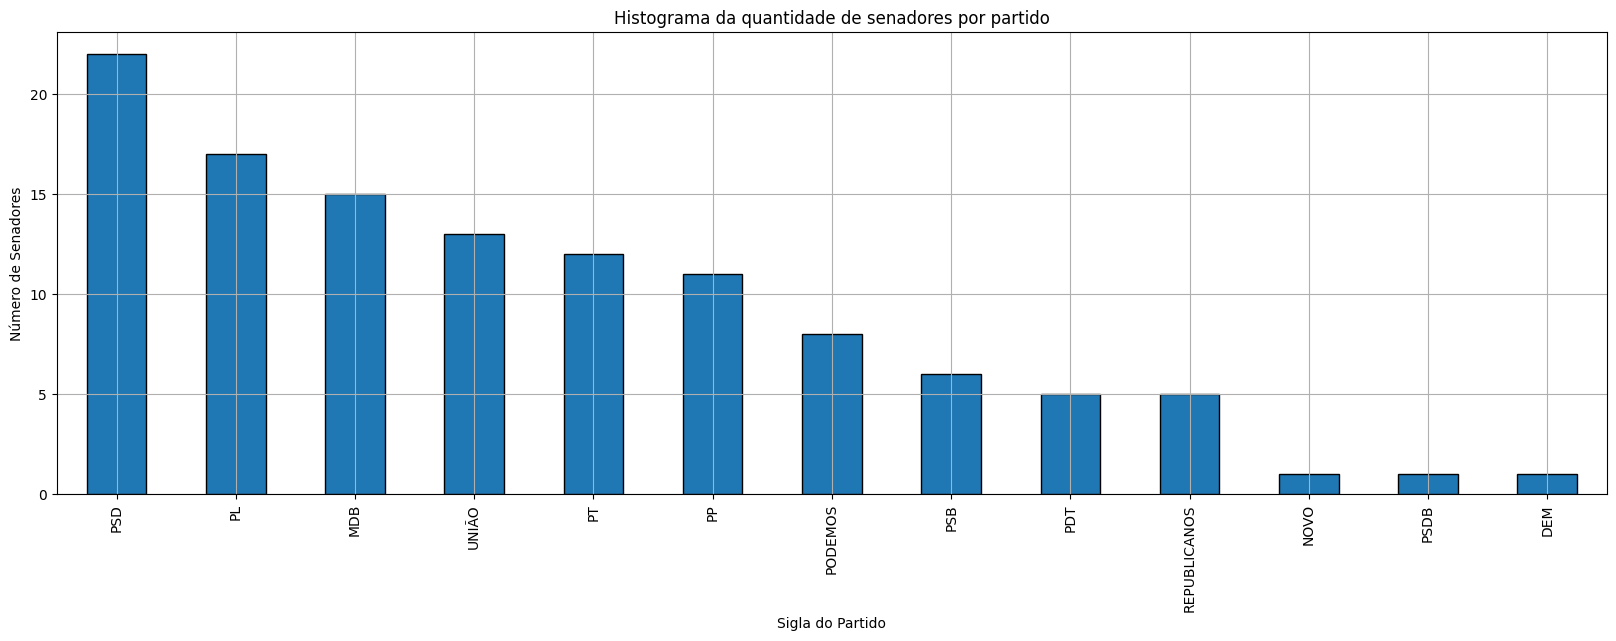

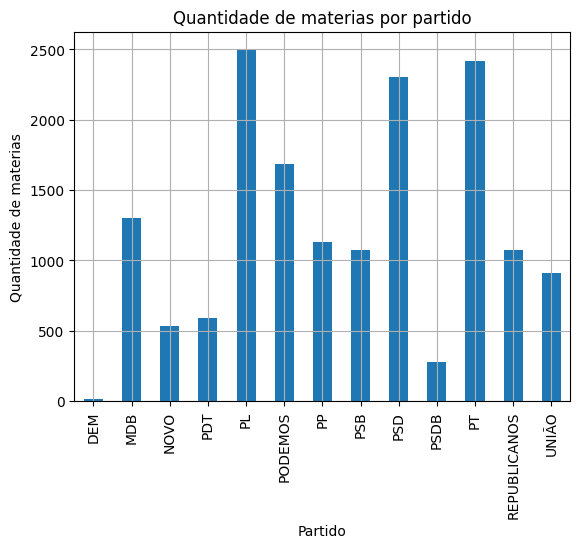

In [106]:
senadores_analytics.histograma_senadores_partido()
senadores_analytics.histograma_materias_por_partido()

In [107]:
class AssuntoMateriaAnalytics():
    """
        Classe para fazer análises sobre os assuntos das matérias legislativas
        
    """
    
    def __init__(self):
        self.api_response = ApiGetter.get("https://legis.senado.leg.br/dadosabertos/materia/assuntos")
        self.parsed_response = ApiXmlParser.parse(self.api_response.content, 'utf-8')
        self.dataframe_assuntos()

    def dataframe_assuntos(self):
        if self.parsed_response is None:
            return None
        try:
            assuntos = self.parsed_response['ListaAssuntos']['Assuntos']['Assunto']
            df_assuntos = pd.DataFrame(assuntos, columns=['Codigo', 'AssuntoGeral', 'AssuntoEspecifico'])
            self.df_assuntos = df_assuntos
        except Exception as e:
            print(e)
            return None
    
    def histograma_assuntos(self):
        """
            Plotar um histograma com a quantidade de materias legislativas por assunto
        """ 
        self.df_assuntos['AssuntoGeral'].value_counts().plot(kind='bar', figsize=(20, 6), edgecolor='black')
        plt.title('Quantidade de assuntos por assunto geral')
        plt.xlabel('Assunto Geral')
        plt.ylabel('Quantidade de Assuntos')
        plt.grid(True)
        plt.show()
    
                                                                

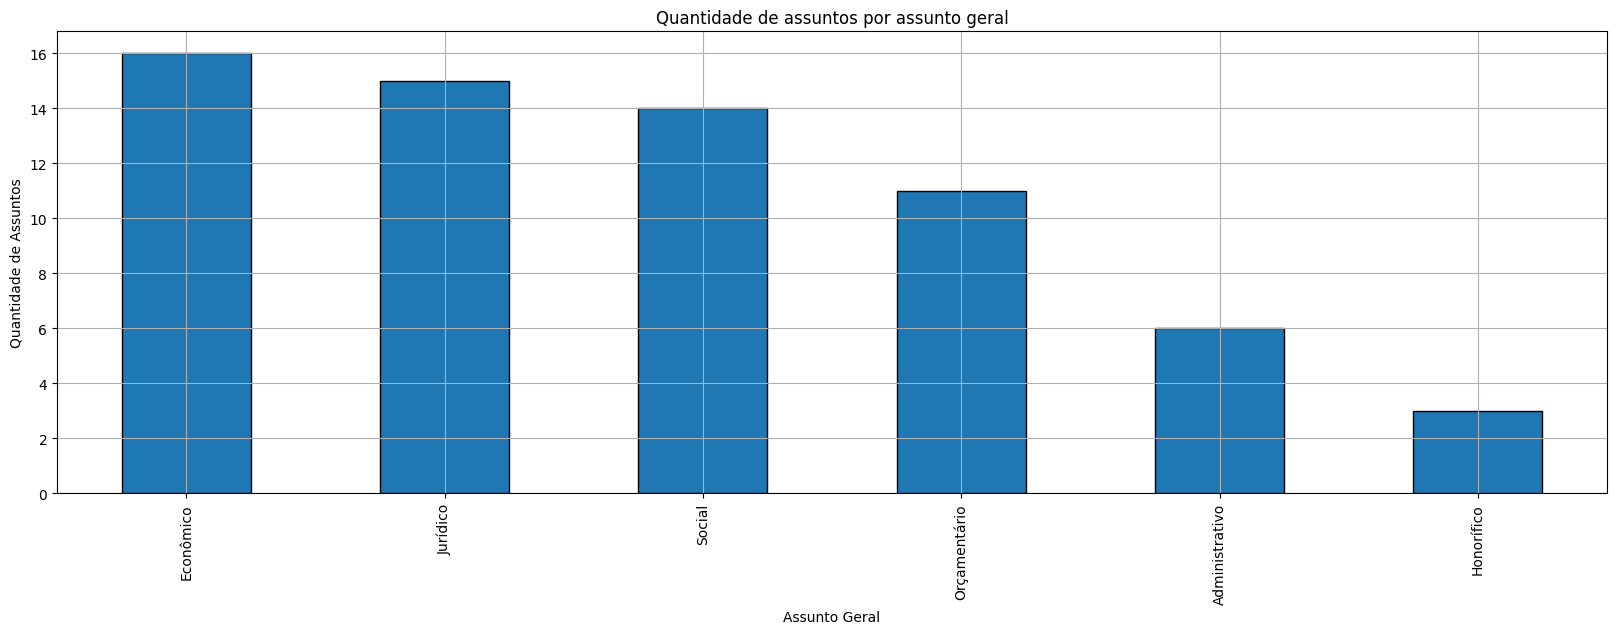

In [108]:
assunto_materia_analytics = AssuntoMateriaAnalytics()
assunto_materia_analytics.histograma_assuntos()

In [109]:
class BlocosPoliticosAnalytics():
    """
        Classe para fazer análises sobre os blocos políticos
    """
    
    def __init__(self):
        self.api_response = ApiGetter.get("https://legis.senado.leg.br/dadosabertos/blocoParlamentar/lista")
        self.parsed_response = ApiXmlParser.parse(self.api_response.content, 'utf-8')
        self.blocos = self.parsed_response['ListaBlocoParlamentar']['Blocos']['Bloco']
    
    def construct_graph(self) -> tuple:
        """
            Construir um grafo com os blocos políticos
        """
        G = nx.Graph()
        edges = []
        labels = []
        for bloco in self.blocos:
            if bloco.get('Membros', None):
                i = 0
                for membro in bloco['Membros']['Membro'][i:len(bloco['Membros']['Membro'])]:
                    for membro2 in bloco['Membros']['Membro'][i+1:len(bloco['Membros']['Membro'])]:
                        if membro['Partido']['SiglaPartido'] != membro2['Partido']['SiglaPartido']:
                            edges.append((membro['Partido']['SiglaPartido'], membro2['Partido']['SiglaPartido']))
                            labels.append(bloco['NomeBloco'])
                    i += 1
        edges_labels = {}
        for i in range(len(edges)):
            edges_labels[edges[i]] = labels[i]
        
        G.add_edges_from(edges)
        return G, edges_labels
        
    def visualize_graph(self, G : nx.Graph, edges_labels : dict):
        """
            Visualizar o grafo dos blocos políticos
        """
        
        pos = nx.spring_layout(G, k=0.3, scale=1,center=(0,0))
        plt.figure(figsize=(20, 20))
        nx.draw(
            G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='pink', alpha=0.9,
            labels={node: node for node in G.nodes()}, font_size=10
        )
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edges_labels,
            font_color='red',
            font_size=6
        )
        plt.axis('off')
        plt.show()

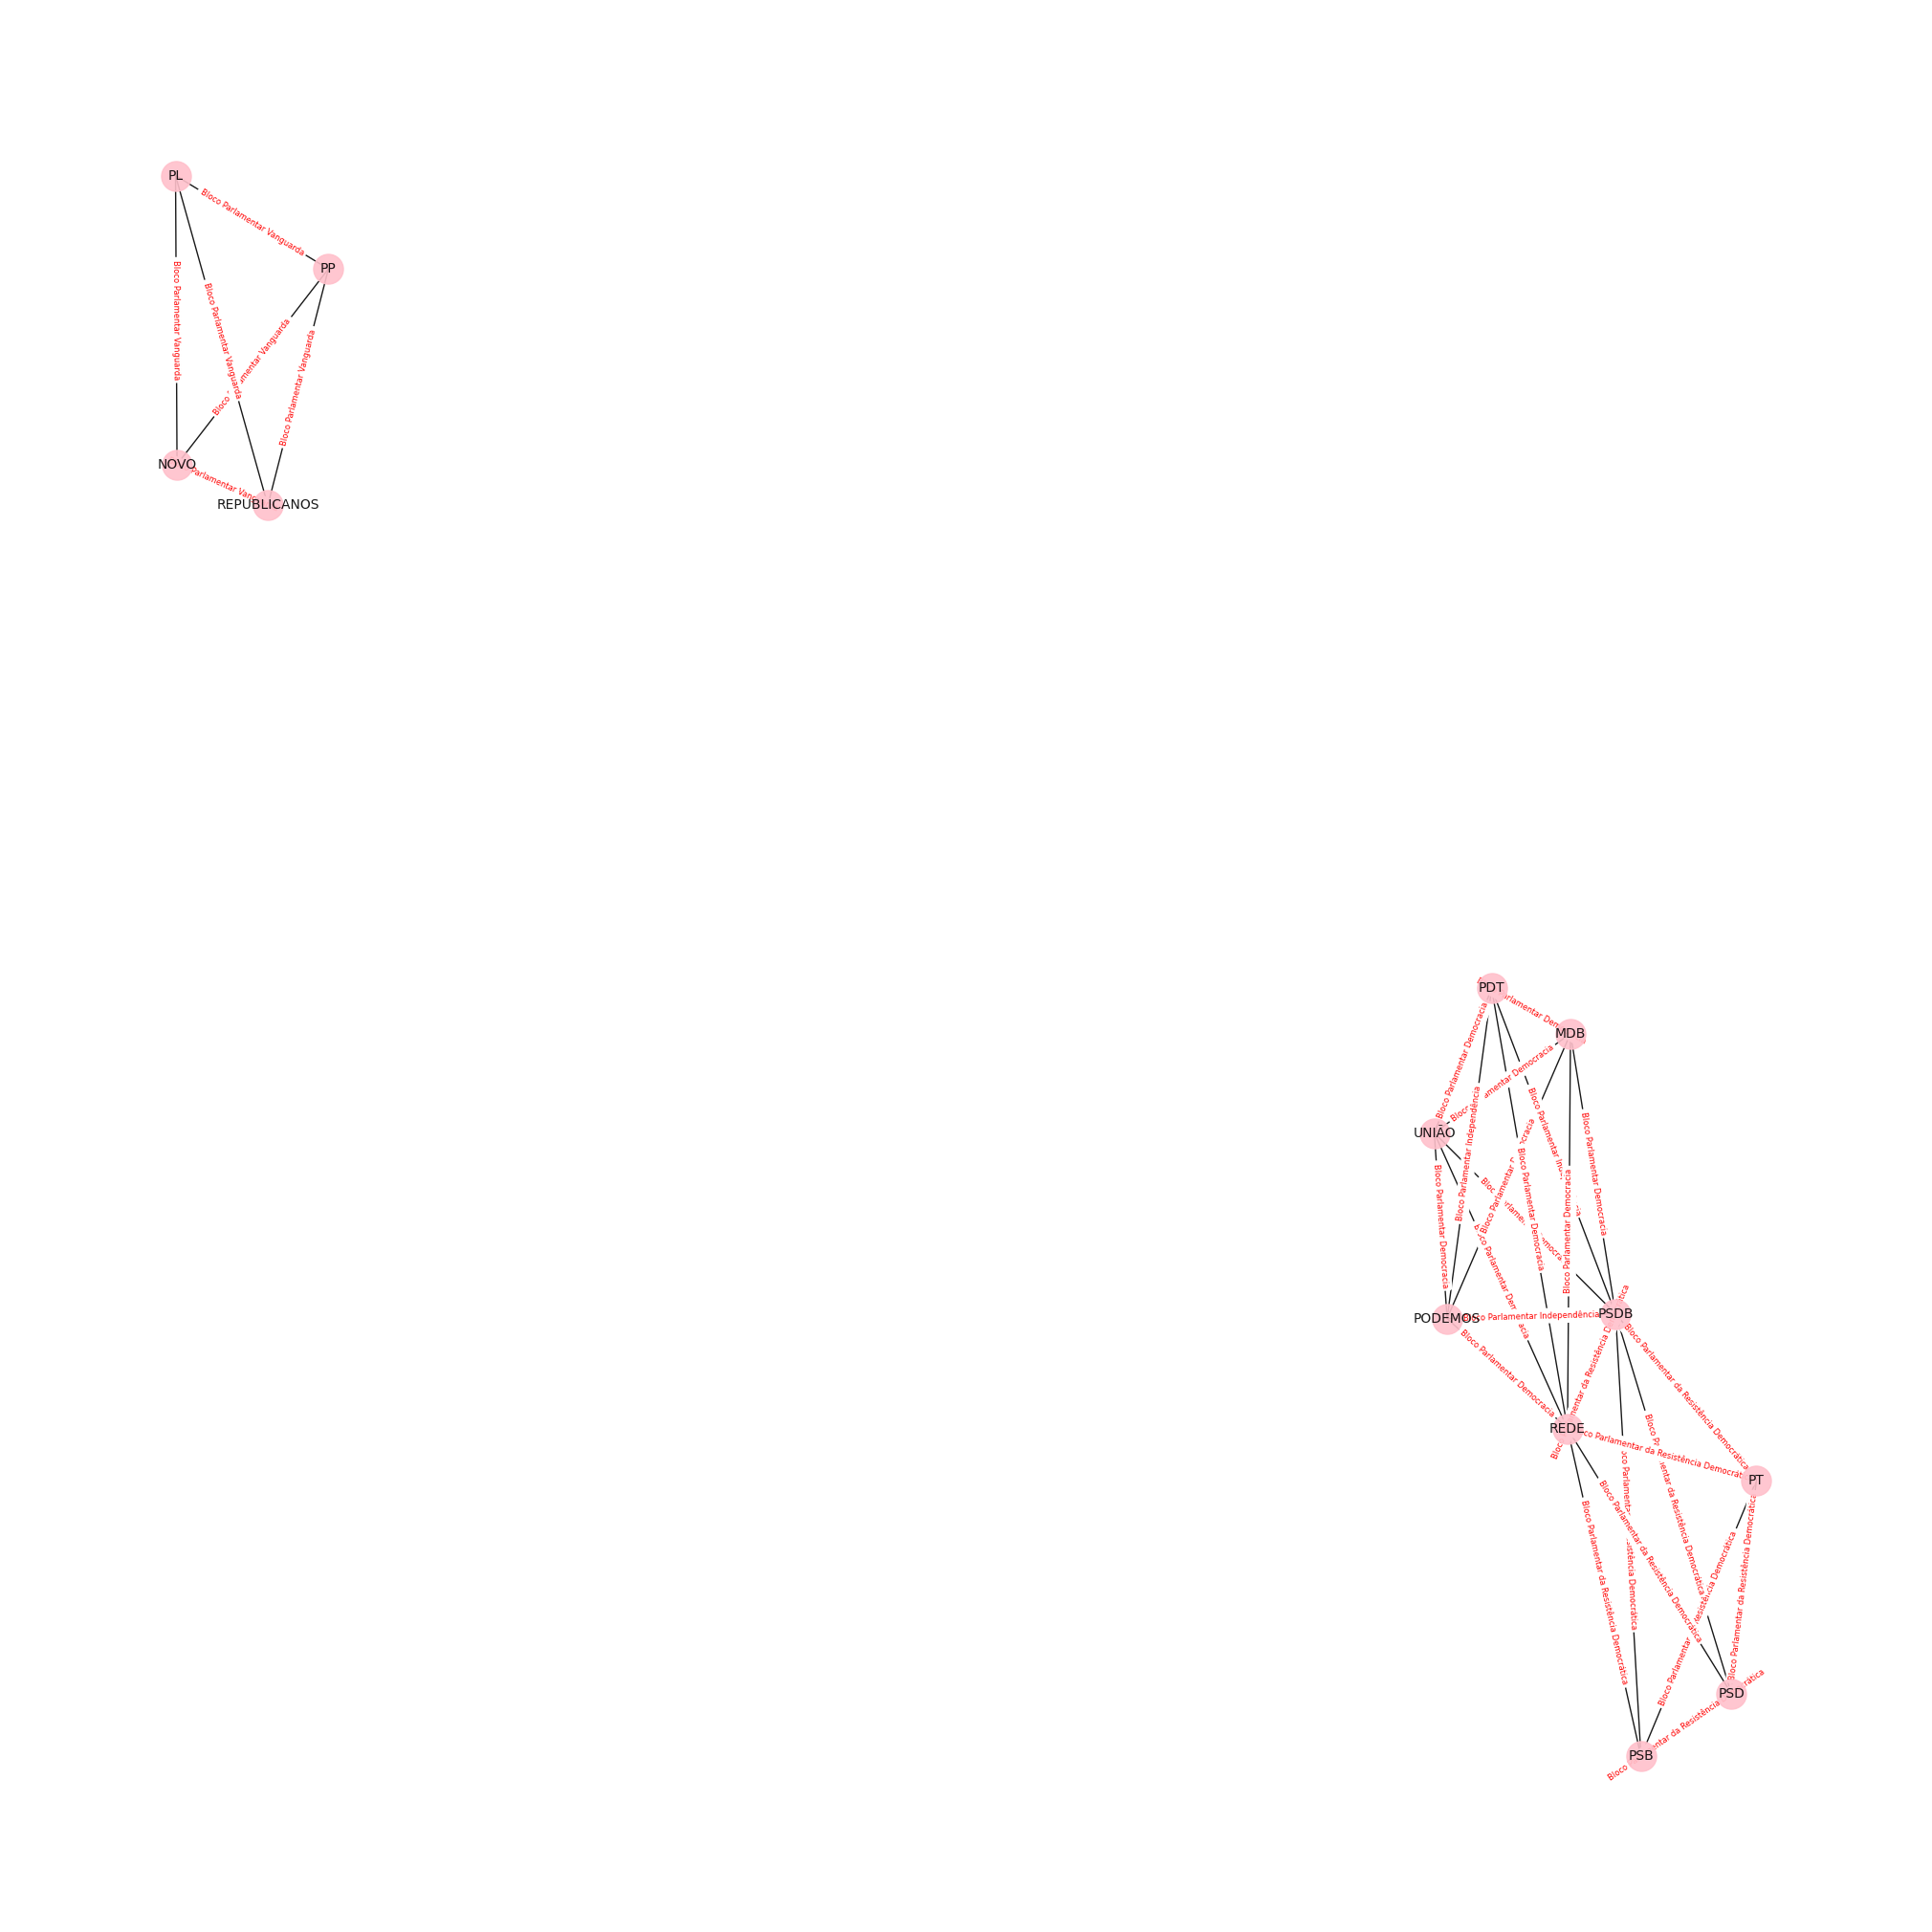

In [110]:
blocos_politicos_analytics = BlocosPoliticosAnalytics()
G, edges_labels = blocos_politicos_analytics.construct_graph()
blocos_politicos_analytics.visualize_graph(G, edges_labels)

In [9]:
class VotacaoPlenarioAnalytics():
    """
        Classe para fazer análises sobre as votações do plenário
    """
    
    def __init__(self):
        self.api_response = ApiGetter.get("https://legis.senado.leg.br/dadosabertos/plenario/votacao/nominal/2024")
        self.parsed_response = ApiXmlParser.parse(self.api_response.content, 'ISO-8859-1')
        self.votacoes = self.parsed_response['ListaVotacoes']['Votacoes']['Votacao']
        self.df_votacoes = None
        self.dataframe_votacoes()
        
    def dataframe_votacoes(self):
        if self.parsed_response is None:
            return None
        try:
            senadores_analytics = SenadoresAnalytics()
            df_votacoes = senadores_analytics.join_senadores_materias().copy()
            df_votacoes['Votos'] = 0
            self.df_votacoes = df_votacoes
            total_sessaos = 0
            for sessao in self.votacoes:
                total_sessaos += 1
                if sessao.get('Votos', None):
                    for voto in sessao['Votos']['VotoParlamentar']:
                        df_votacoes.loc[voto['CodigoParlamentar'], 'Votos'] += 1
            df_votacoes['PorcentagemVotos'] = df_votacoes['Votos'] / total_sessaos * 100
            self.df_votacoes = df_votacoes
        except Exception as e:
            print(e)
            return None
        
    def histograma_votacoes_senadores(self):
        df_senadores_copy_atuais = self.df_votacoes[self.df_votacoes['Afastamento'] == '0']
        df_senadores_copy_atuais['PorcentagemVotos'].plot(kind='hist', bins=20, edgecolor='black')
        plt.title('Histograma de votos dos senadores')
        plt.xlabel('Número de Votos (%)')
        plt.ylabel('Número de Senadores')
        plt.yticks(range(0, 150, 10))
        plt.xticks(range(50, 105, 5))
        plt.grid(True)
        plt.show()
        
    def histograma_votacoes_partido(self):
        df_senadores_copy_atuais = self.df_votacoes[self.df_votacoes['Afastamento'] == '0']
        df_senadores_copy_atuais.groupby('SiglaPartido')['PorcentagemVotos'].mean().plot(kind='bar')
        plt.title('Porcentagem de votos por partido')
        plt.xlabel('Partido')
        plt.ylabel('Porcentagem de votos')
        plt.grid(True)
        plt.show()

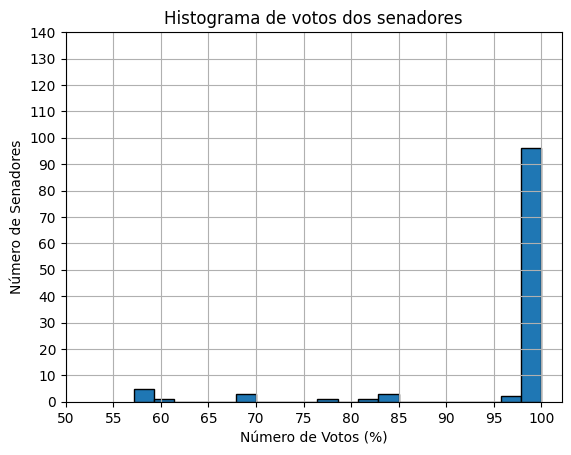

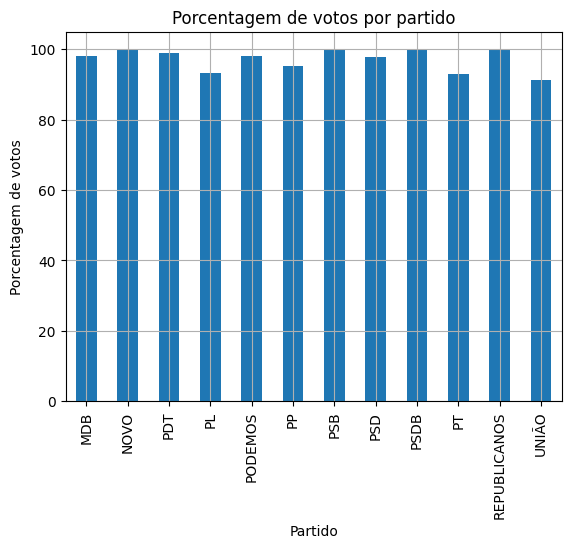

In [10]:
votacao_plenario_analytics = VotacaoPlenarioAnalytics()
votacao_plenario_analytics.histograma_votacoes_senadores()
votacao_plenario_analytics.histograma_votacoes_partido()